# Initialization

In [262]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000  # 100k elements in the stream
NUM_UNIQUE = 10000  # 10k unique elements
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)

# Generate the stream
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)
np.random.shuffle(stream)

num_unique_elements = len(np.unique(stream))

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {num_unique_elements}")
print(f"First 10 elements of the stream: {stream[:10]}")

# Generate logarithmically spaced sketch sizes
sketch_sizes = [100, 300, 1000, 3000, 10000]
print(f"Sketch sizes: {sketch_sizes}")

Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7373 4170 6775 6174 3168 6847 9084 1929 1287 1598]
Sketch sizes: [100, 300, 1000, 3000, 10000]


In [263]:
from functools import lru_cache

@lru_cache(maxsize=None)
def hash_fn(element: int, seed: int = 0) -> int:
    """
    Hashes the element using the given seed.
    """
    return (hash((element, seed)) % 2**32) / 2**32

def hash_stream(stream: np.ndarray, seed: int = 0) -> np.ndarray:
    """
    Hashes the stream using the given seed.
    """
    return np.array([hash_fn(element, seed) for element in stream])

def multi_hash_stream(stream: np.ndarray, seeds: np.ndarray) -> np.ndarray:
    """
    Hashes the stream using multiple seeds.
    """
    return np.array([hash_stream(stream, seed) for seed in seeds])


## Flajolet Martin

### Flajolet Martin - Alpha Version

In [264]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    hashed_stream = hash_stream(stream)
    return 1 / np.min(hashed_stream)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin(stream):.2f}")

Estimated number of unique elements: 23583.04


### Flajolet Martin - Beta Version

In [265]:
from typing import Optional

def flajolet_martin_beta(stream: np.ndarray, s: int, seeds: Optional[np.ndarray] = None) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seeds: numpy array of seeds for the hash functions
    :return: estimated number of distinct elements
    """
    seeds = np.arange(s) if seeds is None else seeds
    assert len(seeds) == s, "Number of seeds must match the number of FM estimators"
    
    estimates = multi_hash_stream(stream, seeds)
    
    Z = np.min(estimates, axis=1)
    return 1 / np.mean(Z) - 1

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_beta(stream, 300):.2f}")

Estimated number of unique elements: 13330.48


### Flajolet Martin - Final Version

In [266]:
from concurrent.futures import ThreadPoolExecutor

def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """

    seed_sets = np.array_split(np.arange(t * s), t)

    with ThreadPoolExecutor() as executor:
            estimates = list(executor.map(lambda seeds: flajolet_martin_beta(stream, s, seeds), seed_sets))
        
    return np.median(estimates)

# Sanity check
print(f"Estimated number of unique elements: {flajolet_martin_final(stream, 3, 100):.2f}")

Estimated number of unique elements: 13869.57


Run 25 times for each sketch size

In [ ]:
delta = 0.05  # 95% confidence interval
delta_beta = 1/3

def process_sketch(sketch_size: int) -> tuple:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: tuple of FM, FM-beta, and FM-final estimates
    """
    epsilon = np.sqrt(np.log(1 / delta) / sketch_size)  # So space complexity is O(log(1/delta)/epsilon^2)
    
    t = int(np.ceil(np.log(1 / delta)))
    s = int(np.ceil(1 / (delta_beta * (epsilon**2))))
        
    print(f"Sketch size: {sketch_size}, Epsilon: {epsilon:.2f}, t: {t}, s: {s}")
    
    # Generate random indices for the stream
    indices = [np.random.choice(len(stream), size=sketch_size, replace=False) for _ in range(NUM_RUNS)]
    
    fm_results = [flajolet_martin(stream[index]) for index in indices]
    fm_beta_results = [flajolet_martin_beta(stream[index], s) for index in indices]
    fm_final_results = [flajolet_martin_final(stream[index], t, s) for index in indices]

    print(f"Sketch size: {sketch_size}, Average FM estimate: {np.mean(fm_results):.2f}, Average FM-beta estimate: {np.mean(fm_beta_results):.2f}, Average FM-final estimate: {np.mean(fm_final_results):.2f}")
    return fm_results, fm_beta_results, fm_final_results

print(f"True number of unique elements: {num_unique_elements}")

results = [process_sketch(sketch_size) for sketch_size in sketch_sizes]

True number of unique elements: 10000
Sketch size: 100, Epsilon: 0.17, t: 3, s: 101
Sketch size: 100, Average FM estimate: 846.66, Average FM-beta estimate: 103.92, Average FM-final estimate: 101.64
Sketch size: 300, Epsilon: 0.10, t: 3, s: 301
Sketch size: 300, Average FM estimate: 1571.70, Average FM-beta estimate: 300.52, Average FM-final estimate: 299.48
Sketch size: 1000, Epsilon: 0.05, t: 3, s: 1002


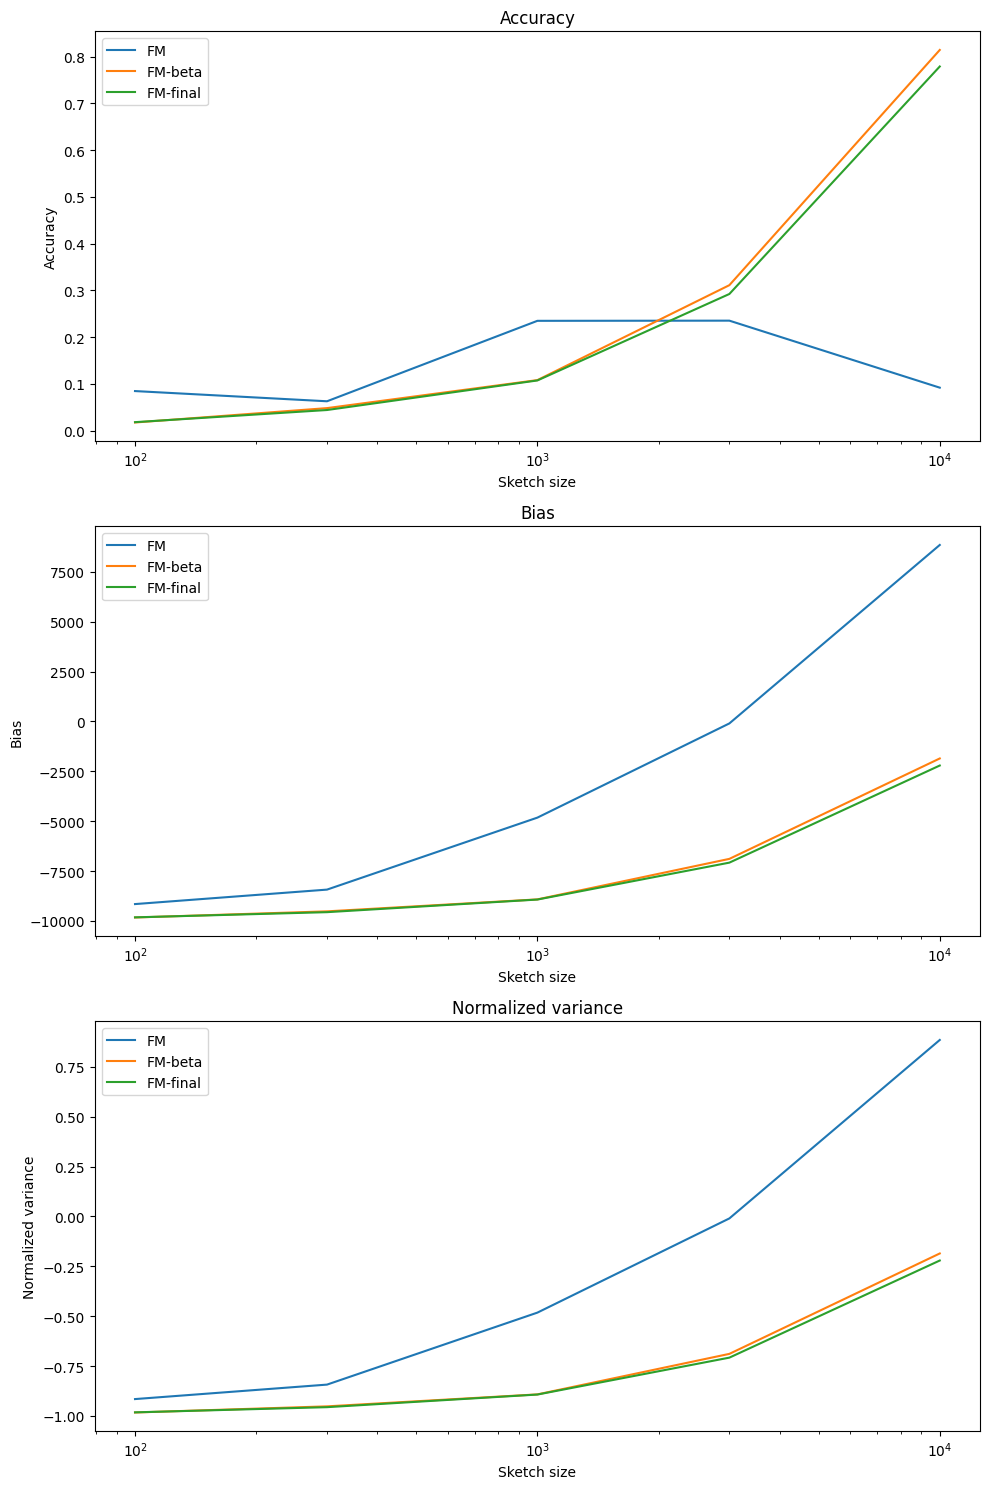

In [ ]:
import matplotlib.pyplot as plt

fm_results = {sketch_size: results[i][0] for i, sketch_size in enumerate(sketch_sizes)}
fm_beta_results = {sketch_size: results[i][1] for i, sketch_size in enumerate(sketch_sizes)}
fm_final_results = {sketch_size: results[i][2] for i, sketch_size in enumerate(sketch_sizes)}

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": np.mean([max(0, 1 - abs(est - true_unique) / true_unique) for est in size_estimates]),
            "bias": np.mean([est - true_unique for est in size_estimates]),
            "normalized_variance": np.mean([((est - true_unique) / true_unique) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM")
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta")
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final")
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM")
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta")
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final")
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM")
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta")
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final")
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()